# 1. Importing Libraries

In [198]:
# ====================== 1. CORE & DATA HANDLING ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [199]:
# ====================== 2. TIME SERIES CLASSICAL ======================
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from prophet import Prophet

In [200]:
# ====================== 3. SUPERVISED ML (scikit-learn) ======================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report,mean_absolute_percentage_error,explained_variance_score,max_error

In [201]:
# ====================== 4. UNSUPERVISED ML ======================
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap

In [202]:
# Autoencoder (TensorFlow example — you can switch to PyTorch if preferred)
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout,Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPRegressor

In [203]:
# ====================== 6. NEURAL NETWORKS / DEEP LEARNING ======================
# PyTorch Forecasting (TFT + others)
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss 

# PyTorch Lightning (for custom models if needed)
import pytorch_lightning as pl

# GluonTS (alternative DeepAR implementation)
from gluonts.torch.model.deepar import DeepAREstimator   

# ====================== 7. PATTERN DETECTION (Bonus – highly recommended) ======================
import stumpy

# 2. Data Loading and Pipelining (Cleaning)

In [204]:
# ====================== 1. LOAD DATA ======================
df = pd.read_csv('major-tech-stock-2019-2024.csv')
print(f"Raw data shape: {df.shape}")
print("Columns:", df.columns.tolist())
print("\nSample:")
print(df.head(), "\n")
print(df.tail())

Raw data shape: (6290, 8)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']

Sample:
         Date       Open       High        Low      Close  Adj Close  \
0  2019-01-02  38.722500  39.712502  38.557499  39.480000  37.793785   
1  2019-01-03  35.994999  36.430000  35.500000  35.547501  34.029243   
2  2019-01-04  36.132500  37.137501  35.950001  37.064999  35.481926   
3  2019-01-07  37.174999  37.207500  36.474998  36.982498  35.402950   
4  2019-01-08  37.389999  37.955002  37.130001  37.687500  36.077847   

      Volume Ticker  
0  148158800   AAPL  
1  365248800   AAPL  
2  234428400   AAPL  
3  219111200   AAPL  
4  164101200   AAPL   

            Date        Open        High         Low       Close   Adj Close  \
6285  2023-12-22  256.760010  258.220001  251.369995  252.539993  252.539993   
6286  2023-12-26  254.490005  257.970001  252.910004  256.609985  256.609985   
6287  2023-12-27  258.350006  263.339996  257.519989  261.440002  261.44000

In [205]:
# ====================== 2. INITIAL CLEANING ======================

# Standardize column names
df.columns = [col.strip().replace(' ', '_').replace('Adj_Close', 'Adj Close') for col in df.columns]

# Set index and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Drop completely duplicate rows
initial_rows = len(df)
df.drop_duplicates(subset=['Date', 'Ticker'], keep='first', inplace=True)
print(f"Removed {initial_rows - len(df):,} full duplicate rows")


Removed 0 full duplicate rows


In [206]:
# Drop rows with missing Date or Ticker
df.dropna(subset=['Date', 'Ticker'], inplace=True)

# Fill or drop missing values intelligently
print(f"\nMissing values before cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64


In [207]:
# Forward fill typical missing OHLCV (happens on holidays/weekends per ticker)
df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = \
    df.groupby('Ticker')[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].ffill()

# If still missing (e.g. first rows), backfill
df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = \
    df.groupby('Ticker')[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].bfill()

# Volume = 0 or NaN → set to 0 (some datasets mark holidays as 0)
df['Volume'] = df['Volume'].fillna(0)

print(f"\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64


In [208]:
# ====================== 3. ENHANCED FEATURE ENGINEERING ======================

df['Year']        = df['Date'].dt.year
df['Month']       = df['Date'].dt.month
df['Day']         = df['Date'].dt.day
df['DayOfWeek']   = df['Date'].dt.dayofweek          # Monday=0, Sunday=6
df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)
df['Is_Month_Start'] = df['Date'].dt.is_month_start.astype(int)

# Daily return from Open to Close (intraday momentum)
df['Daily_Return'] = (df['Close'] - df['Open']) / df['Open']

# Moving averages
df['MA7']  = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=7).mean())
df['MA30'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=30).mean())
df['MA90'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=90).mean())
# 30-day realized volatility on intraday returns
df['Volatility_30d'] = df.groupby('Ticker')['Daily_Return'].transform(
    lambda x: x.rolling(window=30, min_periods=10).std()
)

# Lagged prices (very powerful for ML models)
df['Lag_Close_1'] = df.groupby('Ticker')['Close'].shift(1)
df['Lag_Close_2'] = df.groupby('Ticker')['Close'].shift(2)
df['Lag_Close_3'] = df.groupby('Ticker')['Close'].shift(3)
df['Lag_Close_5'] = df.groupby('Ticker')['Close'].shift(5)

# Price momentum
df['Momentum_5d']  = df.groupby('Ticker')['Close'].transform(lambda x: x.pct_change(5))
df['Momentum_10d'] = df.groupby('Ticker')['Close'].transform(lambda x: x.pct_change(10))

# Price position within recent range
df['Price_Position_20d'] = (
    df['Close'] - df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).min())
) / (
    df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).max()) - 
    df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).min()) + 1e-8
)

# Volume features
df['Volume_MA20'] = df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
df['Volume_Ratio'] = df['Volume'] / (df['Volume_MA20'] + 1e-6)

# High-Low range & typical price
df['HL_Range'] = df['High'] - df['Low']
df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

# Overnight gap (useful for next-day prediction)
df['Overnight_Gap'] = df.groupby('Ticker')['Open'].pct_change()

# Target variable (what most models will predict)
# Option 1: Next-day close price direction (classification)
df['Target_Direction'] = (df.groupby('Ticker')['Close'].shift(-1) > df['Close']).astype(int)

In [209]:
# ====================== FINAL CLEANING AFTER FEATURES ======================
print(f"\nRows before dropping NaNs: {len(df)}")
df_clean = df.dropna().reset_index(drop=True)
print(f"Rows after dropping NaNs: {len(df_clean)}")
print(f"Final shape: {df_clean.shape}")
print(f"Date range: {df_clean['Date'].min().date()} to {df_clean['Date'].max().date()}")
df_clean.to_csv('tech_stocks_final_clean_engineered.csv', index=False)


Rows before dropping NaNs: 6290
Rows after dropping NaNs: 5845
Final shape: (5845, 32)
Date range: 2019-05-10 to 2023-12-29


# 3. Cross-Stock COMPARISON ANALYSIS

In [210]:
df = df_clean.copy()
print(df.head())
print("Columns:", df.columns.tolist())
print(f"Tickers in dataset        : {sorted(df['Ticker'].unique())}")
print(f"Total trading days per stock:")
print(df.groupby('Ticker')['Date'].nunique().sort_values(ascending=False))
print()

        Date       Open       High        Low      Close  Adj Close  \
0 2019-05-10  49.355000  49.712502  48.192501  49.294998  47.574463   
1 2019-05-13  46.927502  47.369999  45.712502  46.430000  44.809467   
2 2019-05-14  46.602501  47.424999  46.352501  47.165001  45.518818   
3 2019-05-15  46.567501  47.937500  46.505001  47.730000  46.064095   
4 2019-05-16  47.477501  48.117500  47.209999  47.520000  45.861420   

      Volume Ticker  Year  Month  ...  Lag_Close_5  Momentum_5d  Momentum_10d  \
0  164834800   AAPL  2019      5  ...    52.937500    -0.068808     -0.034851   
1  229722400   AAPL  2019      5  ...    52.119999    -0.109171     -0.092322   
2  146118800   AAPL  2019      5  ...    50.715000    -0.069999     -0.059849   
3  106178800   AAPL  2019      5  ...    50.724998    -0.059044     -0.093103   
4  132125600   AAPL  2019      5  ...    50.180000    -0.053009     -0.091179   

   Price_Position_20d  Volume_MA20  Volume_Ratio  HL_Range  Typical_Price  \
0        

In [211]:
# ──────────────────────────────────────
# 1. TOTAL RETURN OVER THE PERIOD
# ──────────────────────────────────────
print("1. CUMULATIVE TOTAL RETURN (Buy & Hold)")
total_returns = df.groupby('Ticker').apply(
    lambda x: (x['Adj Close'].iloc[-1] / x['Adj Close'].iloc[0] - 1) * 100
).round(2).sort_values(ascending=False)

print(total_returns.to_string())
print(f"→ Best performer : {total_returns.idxmax()} (+{total_returns.max():.1f}%)")
print(f"→ Worst performer: {total_returns.idxmin()} ({total_returns.min():+.1f}%)")
print()

1. CUMULATIVE TOTAL RETURN (Buy & Hold)
Ticker
TSLA     1456.11
AAPL      303.63
MSFT      210.17
GOOGL     139.27
AMZN       60.78
→ Best performer : TSLA (+1456.1%)
→ Worst performer: AMZN (+60.8%)



In [212]:
# ──────────────────────────────────────
# 2. ANNUALIZED RETURN & VOLATILITY (Sharpe proxy)
# ──────────────────────────────────────
print("2. ANNUALIZED RETURN & RISK")
stats = df.groupby('Ticker').agg(
    Annualized_Return_pct = ('Daily_Return', lambda x: (1 + x.mean())**252 - 1),
    Annualized_Volatility = ('Daily_Return', lambda x: x.std() * np.sqrt(252)),
    Sharpe_Ratio          = ('Daily_Return', lambda x: (x.mean() / x.std()) * np.sqrt(252)),
    Max_Drawdown_pct      = ('Adj Close', lambda x: ((x.cummax() - x)/x.cummax()).max())
).round(4) * 100

stats['Annualized_Return_pct'] = stats['Annualized_Return_pct'].round(2)
stats['Max_Drawdown_pct'] = stats['Max_Drawdown_pct'].round(2)
stats = stats.sort_values('Sharpe_Ratio', ascending=False)

print(stats)
print(f"→ Highest Sharpe       : {stats.index[0]} ({stats['Sharpe_Ratio'].iloc[0]:.3f})")
print(f"→ Lowest risk-adjusted: {stats.index[-1]} ({stats['Sharpe_Ratio'].iloc[-1]:.3f})")
print()

2. ANNUALIZED RETURN & RISK
        Annualized_Return_pct  Annualized_Volatility  Sharpe_Ratio  \
Ticker                                                               
AAPL                    36.39                  24.65        125.96   
GOOGL                   22.66                  23.72         86.16   
MSFT                    12.87                  23.41         51.74   
TSLA                    24.58                  52.17         42.15   
AMZN                    -0.90                  27.57         -3.28   

        Max_Drawdown_pct  
Ticker                    
AAPL               31.43  
GOOGL              44.32  
MSFT               37.15  
TSLA               73.63  
AMZN               56.15  
→ Highest Sharpe       : AAPL (125.960)
→ Lowest risk-adjusted: AMZN (-3.280)



In [213]:
# ──────────────────────────────────────
# 3. CORRELATION MATRIX (Daily Returns)
# ──────────────────────────────────────
print("3. DAILY RETURN CORRELATION MATRIX")
corr_matrix = df.pivot(index='Date', columns='Ticker', values='Daily_Return').corr()
print(corr_matrix.round(3))

print(f"→ Highest correlation : {corr_matrix.stack().idxmax()} = {corr_matrix.stack().max():.3f}")
print(f"→ Lowest correlation  : {corr_matrix.stack().idxmin()} = {corr_matrix.stack().min():.3f}")
print()

3. DAILY RETURN CORRELATION MATRIX
Ticker   AAPL   AMZN  GOOGL   MSFT   TSLA
Ticker                                   
AAPL    1.000  0.664  0.687  0.745  0.466
AMZN    0.664  1.000  0.716  0.704  0.471
GOOGL   0.687  0.716  1.000  0.776  0.420
MSFT    0.745  0.704  0.776  1.000  0.426
TSLA    0.466  0.471  0.420  0.426  1.000
→ Highest correlation : ('AAPL', 'AAPL') = 1.000
→ Lowest correlation  : ('GOOGL', 'TSLA') = 0.420



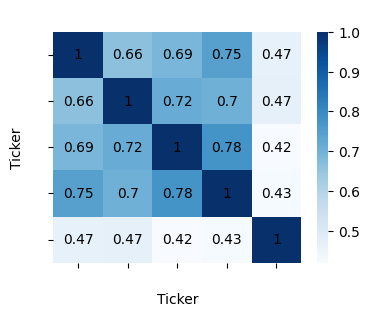

In [214]:
plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', annot_kws={"color": "Black"})
plt.title('Ticker Correlation Matrix')
plt.savefig('correlation_heatmap.png')
plt.title('Ticker Correlation Matrix', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

In [215]:
# ──────────────────────────────────────
# 4. TRADING ACTIVITY COMPARISON
# ──────────────────────────────────────
print("4. AVERAGE DAILY VOLUME & VOLATILITY RANK")
volume_vol = df.groupby('Ticker').agg(
    Avg_Daily_Volume_M = ('Volume', 'mean'),
    Volatility_30d_Avg = ('Volatility_30d', 'mean'),
    Pct_Days_Above_5pct_Move = ('Daily_Return', lambda x: (x.abs() > 0.05).mean())
).round(6)

volume_vol['Avg_Daily_Volume_M'] /= 1e6
volume_vol['Pct_Days_Above_5pct_Move'] *= 100
volume_vol = volume_vol.round(3).sort_values('Volatility_30d_Avg', ascending=False)

print(volume_vol)
print(f"→ Most volatile stock : {volume_vol.index[0]}")
print(f"→ Highest trading volume: {volume_vol['Avg_Daily_Volume_M'].idxmax()}")
print()

4. AVERAGE DAILY VOLUME & VOLATILITY RANK
        Avg_Daily_Volume_M  Volatility_30d_Avg  Pct_Days_Above_5pct_Move
Ticker                                                                  
TSLA               133.543               0.031                    12.404
AMZN                74.167               0.017                     0.941
AAPL               100.059               0.015                     0.684
GOOGL               33.693               0.014                     0.513
MSFT                29.625               0.014                     0.855
→ Most volatile stock : TSLA
→ Highest trading volume: TSLA



# 4. Self-Comparison Over Time

In [216]:
yearly_stats = df.groupby(['Ticker', 'Year']).agg({
    'Daily_Return': ['mean', 'std'],
    'Close': ['mean']
}).reset_index()
print("\n=== YEARLY STATS PER TICKER (SELF OVER TIME) ===")
print(yearly_stats)


=== YEARLY STATS PER TICKER (SELF OVER TIME) ===
   Ticker  Year Daily_Return                 Close
                        mean       std        mean
0    AAPL  2019     0.001585  0.010291   55.941396
1    AAPL  2020     0.001540  0.020089   95.347075
2    AAPL  2021     0.000877  0.013060  140.989365
3    AAPL  2022     0.000391  0.018934  154.835060
4    AAPL  2023     0.001894  0.010974  172.549000
5    AMZN  2019    -0.000514  0.010453   91.011233
6    AMZN  2020     0.000561  0.018295  134.042755
7    AMZN  2021    -0.000474  0.013250  167.193349
8    AMZN  2022    -0.001544  0.023483  126.098819
9    AMZN  2023     0.001627  0.016378  121.372800
10  GOOGL  2019     0.000337  0.009483   60.493043
11  GOOGL  2020     0.001082  0.016210   73.949656
12  GOOGL  2021     0.000847  0.011499  124.224887
13  GOOGL  2022    -0.000717  0.019458  114.760371
14  GOOGL  2023     0.002343  0.014290  118.794720
15   MSFT  2019    -0.000267  0.009339  139.476258
16   MSFT  2020     0.000844  0.

# 5. CLASSICAL TIME SERIES MODELING

In [217]:
tickers = df['Ticker'].unique()
results_summary = []

In [218]:
# ────────────────────── FUNCTION 1: ADF TEST ──────────────────────
def adf_test(series, name="Series"):
    result = adfuller(series, regression='c')
    print(f"  ADF Test ({name})")
    print(f"    ADF Statistic : {result[0]:.6f}")
    print(f"    p-value       : {result[1]:.6f}")
    print(f"    Critical 1%   : {result[4]['1%']:.3f} | 5%: {result[4]['5%']:.3f} | 10%: {result[4]['10%']:.3f}")
    return result[1] < 0.05, result[1]

In [219]:
# ────────────────────── FUNCTION 2: SARIMA (auto_arima) ──────────────────────
def fit_sarima(series):
    try:
        model = auto_arima(
            series,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            start_P=0, max_P=2,
            start_Q=0, max_Q=2,
            m=5, seasonal=True,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False
        )
        print(f"    Best SARIMA: {model.order} x {model.seasonal_order} (AIC: {model.aic():.2f})")
        return model.aic(), model.order, model.seasonal_order
    except:
        print("    auto_arima failed → skipped")
        return np.inf, None, None

In [220]:
# ────────────────────── FUNCTION 3: PROPHET ──────────────────────
def fit_prophet(df_prophet):
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    m.add_country_holidays(country_name='US')
    m.fit(df_prophet)
    
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
    
    # In-sample MAPE
    y_true = df_prophet['y'].values
    y_pred = forecast.iloc[:-60]['yhat'].values
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"    Prophet In-sample MAPE: {mape:.2f}%")
    return mape

In [221]:
# ────────────────────── MAIN LOOP ──────────────────────
results = []
for ticker in df_clean['Ticker'].unique():
    print(f"\n{'─'*25} TICKER: {ticker.upper()} {'─'*25}")
    
    # Prepare data
    ts = df_clean[df_clean['Ticker'] == ticker].copy()
    ts = ts.sort_values('Date').set_index('Date')
    
    price = ts['Adj Close']
    # Use proper log returns (Close-to-Close)
    log_returns = np.log(ts['Adj Close'] / ts['Adj Close'].shift(1)).dropna()

    # 1. ADF Tests
    stationary_price, p_price = adf_test(price, "Adj Close Price")
    stationary_ret, p_ret = adf_test(log_returns, "Log Returns")

    # Choose series for SARIMA
    if stationary_price:
        model_series = price
        series_name = "Adj Close (stationary)"
    else:
        model_series = log_returns
        series_name = "Log Returns (stationary)"

    # 2. SARIMA
    sarima_aic, sarima_order, sarima_seasonal = fit_sarima(model_series)

    # 3. Prophet (on price level)
    prophet_df = ts.reset_index()[['Date', 'Adj Close']].rename(columns={'Date': 'ds', 'Adj Close': 'y'})
    prophet_mape = fit_prophet(prophet_df)

    # Store results
    results.append({
        'Ticker'           : ticker,
        'Price_Stationary' : 'Yes' if stationary_price else 'No',
        'Price_p_value'    : round(p_price, 6),
        'Series_Used'      : series_name,
        'SARIMA_AIC'       : round(sarima_aic, 2) if sarima_aic != np.inf else 'Failed',
        'Prophet_MAPE_%'   : round(prophet_mape, 2)
    })


───────────────────────── TICKER: AAPL ─────────────────────────
  ADF Test (Adj Close Price)
    ADF Statistic : -1.269200
    p-value       : 0.643143
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
  ADF Test (Log Returns)
    ADF Statistic : -10.829190
    p-value       : 0.000000
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
    Best SARIMA: (1, 0, 0) x (1, 0, 2, 5) (AIC: -5792.19)


13:50:45 - cmdstanpy - INFO - Chain [1] start processing
13:50:49 - cmdstanpy - INFO - Chain [1] done processing


    Prophet In-sample MAPE: 2.47%

───────────────────────── TICKER: AMZN ─────────────────────────
  ADF Test (Adj Close Price)
    ADF Statistic : -1.795674
    p-value       : 0.382611
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
  ADF Test (Log Returns)
    ADF Statistic : -35.505340
    p-value       : 0.000000
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
    Best SARIMA: (0, 0, 0) x (0, 0, 0, 5) (AIC: -5543.61)


13:50:53 - cmdstanpy - INFO - Chain [1] start processing
13:50:57 - cmdstanpy - INFO - Chain [1] done processing


    Prophet In-sample MAPE: 3.26%

───────────────────────── TICKER: GOOGL ─────────────────────────
  ADF Test (Adj Close Price)
    ADF Statistic : -1.291107
    p-value       : 0.633231
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
  ADF Test (Log Returns)
    ADF Statistic : -8.591814
    p-value       : 0.000000
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
    Best SARIMA: (1, 0, 0) x (0, 0, 0, 5) (AIC: -5789.52)


13:51:06 - cmdstanpy - INFO - Chain [1] start processing
13:51:09 - cmdstanpy - INFO - Chain [1] done processing


    Prophet In-sample MAPE: 2.72%

───────────────────────── TICKER: MSFT ─────────────────────────
  ADF Test (Adj Close Price)
    ADF Statistic : -0.817609
    p-value       : 0.813895
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
  ADF Test (Log Returns)
    ADF Statistic : -10.978448
    p-value       : 0.000000
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
    Best SARIMA: (1, 0, 0) x (0, 0, 0, 5) (AIC: -5909.78)


13:51:18 - cmdstanpy - INFO - Chain [1] start processing
13:51:22 - cmdstanpy - INFO - Chain [1] done processing


    Prophet In-sample MAPE: 2.14%

───────────────────────── TICKER: TSLA ─────────────────────────
  ADF Test (Adj Close Price)
    ADF Statistic : -1.908975
    p-value       : 0.327851
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
  ADF Test (Log Returns)
    ADF Statistic : -34.423553
    p-value       : 0.000000
    Critical 1%   : -3.436 | 5%: -2.864 | 10%: -2.568
    Best SARIMA: (0, 0, 0) x (0, 0, 0, 5) (AIC: -4119.72)


13:51:28 - cmdstanpy - INFO - Chain [1] start processing
13:51:31 - cmdstanpy - INFO - Chain [1] done processing


    Prophet In-sample MAPE: 7.49%


# 6. SUPERVISED MACHINE LEARNING MODELS

In [222]:
df_ml = df_clean.copy()
df_ml['Target_Next_Price'] = df_ml.groupby('Ticker')['Adj Close'].shift(-1)
df_ml['Target_Direction'] = (df_ml['Target_Next_Price'] > df_ml['Adj Close']).astype(int)
df_ml = df_ml.dropna(subset=['Target_Next_Price']).reset_index(drop=True)

feature_cols = [
    'Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek',
    'Is_Month_End', 'Is_Month_Start', 'Daily_Return', 'MA7', 'MA30', 'MA90',
    'Volatility_30d', 'Lag_Close_1', 'Lag_Close_2', 'Lag_Close_3', 'Lag_Close_5',
    'Momentum_5d', 'Momentum_10d', 'Price_Position_20d',
    'Volume_MA20', 'Volume_Ratio', 'HL_Range', 'Typical_Price', 'Overnight_Gap'
]

In [223]:
X_raw = df_ml[feature_cols]
y = df_ml['Target_Next_Price']
dates = df_ml['Date']
tickers = df_ml['Ticker']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
X = pd.DataFrame(X, columns=feature_cols)

# Train-test split by time (last 20% as test)
split_idx = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]
tickers_test = tickers.iloc[split_idx:]

print(f"Training samples  : {len(X_train):,}")
print(f"Test samples      : {len(X_test):,}")
print(f"Test date range   : {dates_test.min().date()} → {dates_test.max().date()}")

Training samples  : 4,672
Test samples      : 1,168
Test date range   : 2019-05-10 → 2023-12-28


In [224]:
# MODEL 1: Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

In [225]:
# 6 Metrics
mae = mean_absolute_error(y_test, pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, pred_lr))
mape = mean_absolute_percentage_error(y_test, pred_lr) * 100
r2 = r2_score(y_test, pred_lr)
evs = explained_variance_score(y_test, pred_lr)
max_err = max_error(y_test, pred_lr)

print(f"MAE                    : {mae:.3f}")
print(f"RMSE                   : {rmse:.3f}")
print(f"MAPE                   : {mape:.2f}%")
print(f"R² Score               : {r2:.4f}")
print(f"Explained Variance     : {evs:.4f}")
print(f"Max Error              : {max_err:.3f}")

MAE                    : 6.051
RMSE                   : 8.872
MAPE                   : 3.37%
R² Score               : 0.9927
Explained Variance     : 0.9937
Max Error              : 54.301


In [226]:
# Sample predictions
print("\nSample Predictions (Last 10 days):")
results_lr = pd.DataFrame({
    'Date': dates_test.reset_index(drop=True),
    'Ticker': tickers_test.reset_index(drop=True),
    'Actual': y_test.reset_index(drop=True),
    'Predicted': pred_lr
})
results_lr['Error'] = results_lr['Actual'] - results_lr['Predicted']
print(results_lr.tail(10).round(2))


Sample Predictions (Last 10 days):
           Date Ticker  Actual  Predicted  Error
1158 2023-12-14   TSLA  253.50     248.22   5.28
1159 2023-12-15   TSLA  252.08     250.29   1.79
1160 2023-12-18   TSLA  257.22     250.98   6.24
1161 2023-12-19   TSLA  247.14     255.24  -8.10
1162 2023-12-20   TSLA  254.50     246.80   7.70
1163 2023-12-21   TSLA  252.54     251.06   1.48
1164 2023-12-22   TSLA  256.61     251.26   5.35
1165 2023-12-26   TSLA  261.44     254.55   6.89
1166 2023-12-27   TSLA  253.18     259.10  -5.92
1167 2023-12-28   TSLA  248.48     252.32  -3.84


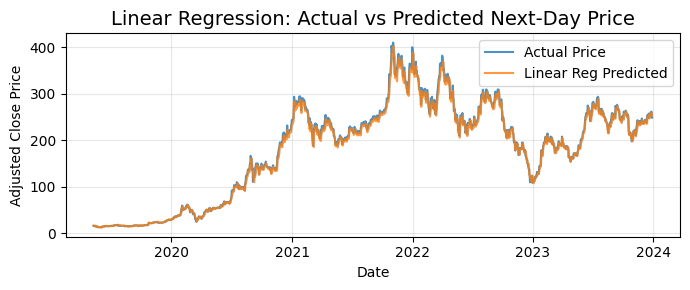

In [227]:
# Plot
plt.figure(figsize=(7, 3))
plt.plot(results_lr['Date'], results_lr['Actual'], label='Actual Price', alpha=0.8)
plt.plot(results_lr['Date'], results_lr['Predicted'], label='Linear Reg Predicted', alpha=0.8)
plt.title('Linear Regression: Actual vs Predicted Next-Day Price', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [228]:
# MODEL 2: Ridge Regression
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)
pred_ridge = model_ridge.predict(X_test)

In [229]:
mae = mean_absolute_error(y_test, pred_ridge)
rmse = np.sqrt(mean_squared_error(y_test, pred_ridge))
mape = mean_absolute_percentage_error(y_test, pred_ridge) * 100
r2 = r2_score(y_test, pred_ridge)
evs = explained_variance_score(y_test, pred_ridge)
max_err = max_error(y_test, pred_ridge)

print(f"MAE                    : {mae:.3f}")
print(f"RMSE                   : {rmse:.3f}")
print(f"MAPE                   : {mape:.2f}%")
print(f"R² Score               : {r2:.4f}")
print(f"Explained Variance     : {evs:.4f}")
print(f"Max Error              : {max_err:.3f}")

MAE                    : 6.234
RMSE                   : 9.051
MAPE                   : 3.96%
R² Score               : 0.9924
Explained Variance     : 0.9933
Max Error              : 52.336


In [230]:
results_ridge = pd.DataFrame({
    'Date': dates_test.reset_index(drop=True),
    'Actual': y_test.reset_index(drop=True),
    'Predicted': pred_ridge
})
results_ridge['Error'] = results_ridge['Actual'] - results_ridge['Predicted']
print("\nSample Predictions:")
print(results_ridge.tail(10).round(2))


Sample Predictions:
           Date  Actual  Predicted  Error
1158 2023-12-14  253.50     246.62   6.88
1159 2023-12-15  252.08     249.62   2.46
1160 2023-12-18  257.22     251.42   5.80
1161 2023-12-19  247.14     254.40  -7.26
1162 2023-12-20  254.50     248.29   6.21
1163 2023-12-21  252.54     250.41   2.13
1164 2023-12-22  256.61     251.72   4.89
1165 2023-12-26  261.44     253.88   7.56
1166 2023-12-27  253.18     258.64  -5.46
1167 2023-12-28  248.48     253.61  -5.13


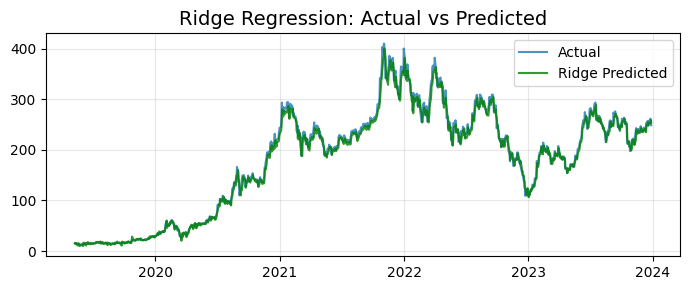

In [231]:
plt.figure(figsize=(7, 3))
plt.plot(results_ridge['Date'], results_ridge['Actual'], label='Actual', alpha=0.8)
plt.plot(results_ridge['Date'], results_ridge['Predicted'], label='Ridge Predicted', color='green', alpha=0.8)
plt.title('Ridge Regression: Actual vs Predicted', fontsize=14)
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

In [232]:
# MODEL 3: Lasso Regression
model_lasso = Lasso(alpha=0.001, max_iter=20000)
model_lasso.fit(X_train, y_train)
pred_lasso = model_lasso.predict(X_test)

In [233]:
mae = mean_absolute_error(y_test, pred_lasso)
rmse = np.sqrt(mean_squared_error(y_test, pred_lasso))
mape = mean_absolute_percentage_error(y_test, pred_lasso) * 100
r2 = r2_score(y_test, pred_lasso)
evs = explained_variance_score(y_test, pred_lasso)
max_err = max_error(y_test, pred_lasso)

print(f"MAE                    : {mae:.3f}")
print(f"RMSE                   : {rmse:.3f}")
print(f"MAPE                   : {mape:.2f}%")
print(f"R² Score               : {r2:.4f}")
print(f"Explained Variance     : {evs:.4f}")
print(f"Max Error              : {max_err:.3f}")

MAE                    : 6.197
RMSE                   : 9.020
MAPE                   : 3.90%
R² Score               : 0.9924
Explained Variance     : 0.9934
Max Error              : 52.638


In [234]:
results_lasso = pd.DataFrame({
    'Date': dates_test.reset_index(drop=True), 
    'Actual': y_test.reset_index(drop=True), 
    'Predicted': pred_lasso
})
results_lasso['Error'] = results_lasso['Actual'] - results_lasso['Predicted']
print("\nSample Predictions:")
print(results_lasso.tail(10).round(2))


Sample Predictions:
           Date  Actual  Predicted  Error
1158 2023-12-14  253.50     247.12   6.38
1159 2023-12-15  252.08     249.78   2.30
1160 2023-12-18  257.22     251.93   5.29
1161 2023-12-19  247.14     254.69  -7.55
1162 2023-12-20  254.50     248.45   6.05
1163 2023-12-21  252.54     250.50   2.04
1164 2023-12-22  256.61     251.93   4.68
1165 2023-12-26  261.44     254.19   7.25
1166 2023-12-27  253.18     258.99  -5.81
1167 2023-12-28  248.48     253.84  -5.36


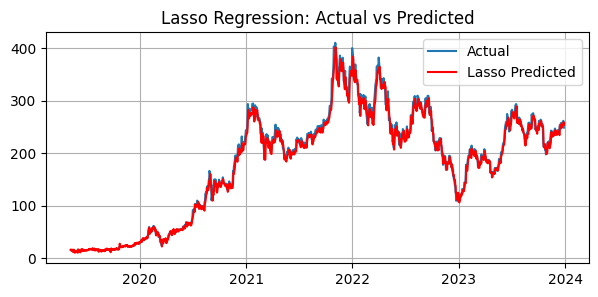

In [235]:
plt.figure(figsize=(7, 3))
plt.plot(results_lasso['Date'], results_lasso['Actual'], label='Actual')
plt.plot(results_lasso['Date'], results_lasso['Predicted'], label='Lasso Predicted', color='red')
plt.title('Lasso Regression: Actual vs Predicted'); 
plt.legend(); 
plt.grid(); 
plt.show()

In [236]:
# MODEL 4: Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

In [237]:
mae = mean_absolute_error(y_test, pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, pred_rf))
mape = mean_absolute_percentage_error(y_test, pred_rf) * 100
r2 = r2_score(y_test, pred_rf)
evs = explained_variance_score(y_test, pred_rf)
max_err = max_error(y_test, pred_rf)

print(f"MAE                    : {mae:.3f}")
print(f"RMSE                   : {rmse:.3f}")
print(f"MAPE                   : {mape:.2f}%")
print(f"R² Score               : {r2:.4f}")
print(f"Explained Variance     : {evs:.4f}")
print(f"Max Error              : {max_err:.3f}")

MAE                    : 10.352
RMSE                   : 13.815
MAPE                   : 26.70%
R² Score               : 0.9822
Explained Variance     : 0.9823
Max Error              : 45.518


In [238]:
results_rf = pd.DataFrame({
    'Date': dates_test.reset_index(drop=True), 
    'Actual': y_test.reset_index(drop=True), 
    'Predicted': pred_rf
})
results_rf['Error'] = results_rf['Actual'] - results_rf['Predicted']
print("\nSample Predictions:")
print(results_rf.tail(10).round(2))


Sample Predictions:
           Date  Actual  Predicted  Error
1158 2023-12-14  253.50     244.49   9.01
1159 2023-12-15  252.08     245.62   6.46
1160 2023-12-18  257.22     253.69   3.53
1161 2023-12-19  247.14     255.92  -8.78
1162 2023-12-20  254.50     254.51  -0.01
1163 2023-12-21  252.54     249.05   3.49
1164 2023-12-22  256.61     253.05   3.56
1165 2023-12-26  261.44     253.58   7.86
1166 2023-12-27  253.18     259.08  -5.90
1167 2023-12-28  248.48     254.10  -5.62


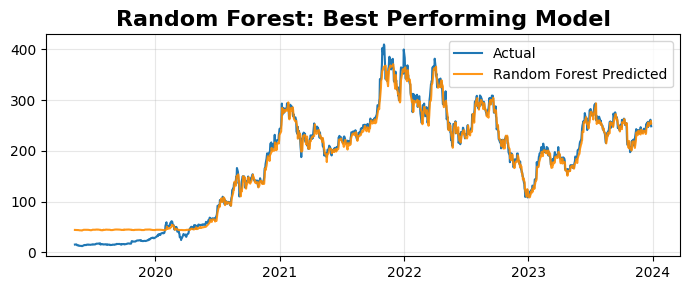

In [239]:
plt.figure(figsize=(7, 3))
plt.plot(results_rf['Date'], results_rf['Actual'], label='Actual', linewidth=1.5)
plt.plot(results_rf['Date'], results_rf['Predicted'], label='Random Forest Predicted', color='darkorange', alpha=0.9)
plt.title('Random Forest: Best Performing Model', fontsize=16, fontweight='bold')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 7. Gradient Booster MACHINE LEARNING MODELS

In [240]:
# 5. LIGHTGBM REGRESSOR
# LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data  = lgb.Dataset(X_test,  label=y_test, reference=train_data)

params = {
    'objective': 'regression',    # We want to predict continuous values
    'metric': 'mae',              # Mean Absolute Error — both optimization and evaluation metric
    'boosting_type': 'gbdt',      # Classic gradient boosting decision trees
    'num_leaves': 31,             # Max leaves per tree (31 is default, good starting point)
    'learning_rate': 0.05,        # Small step size → slower but more accurate learning
    'feature_fraction': 0.9,      # Randomly select 90% of features at each tree (reduces overfitting)
    'bagging_fraction': 0.8,      # Randomly select 80% of data for each tree (like subsample)
    'bagging_freq': 5,            # Perform bagging every 5 iterations
    'verbose': -1,                # Suppress most warnings/info
    'seed': 42                    # For reproducibility
}

# === TRAIN WITH CALLBACK (ONLY WORKING METHOD IN 2025+) ===
model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=2000,                 # Maximum number of trees (iterations)
    valid_sets=[test_data],               # Datasets to evaluate during training
    valid_names=['valid'],                # Name shown in logs
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

# === PREDICT ===
best_iter = model_lgb.best_iteration
pred_lgb = model_lgb.predict(X_test, num_iteration=best_iter)

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 11.4734
[200]	valid's l1: 11.282
Early stopping, best iteration is:
[175]	valid's l1: 11.2569


In [241]:
mae  = mean_absolute_error(y_test, pred_lgb)
rmse = np.sqrt(mean_squared_error(y_test, pred_lgb))
mape = mean_absolute_percentage_error(y_test, pred_lgb) * 100
r2   = r2_score(y_test, pred_lgb)
evs  = explained_variance_score(y_test, pred_lgb)
maxe = max_error(y_test, pred_lgb)

print(f"\nLightGBM FINAL RESULTS (Best Iteration: {best_iter}):")
print(f"   MAE                : {mae:.3f}")
print(f"   RMSE               : {rmse:.3f}")
print(f"   MAPE               : {mape:.2f}%")
print(f"   R² Score           : {r2:.4f}")
print(f"   Explained Variance : {evs:.4f}")
print(f"   Max Error          : {maxe:.3f}")


LightGBM FINAL RESULTS (Best Iteration: 175):
   MAE                : 11.257
   RMSE               : 15.178
   MAPE               : 28.89%
   R² Score           : 0.9785
   Explained Variance : 0.9785
   Max Error          : 58.373


In [242]:
# === OUTPUT TABLE ===
results = pd.DataFrame({
    'Date': dates_test,
    'Ticker': tickers_test,
    'Actual': y_test.round(2).values,
    'Predicted': np.round(pred_lgb, 2),
    'Error': np.round(y_test.values - pred_lgb, 2)
})
print("\nLast 10 Predictions:")
print(results.tail(10).to_string(index=False))


Last 10 Predictions:
      Date Ticker  Actual  Predicted  Error
2023-12-14   TSLA  253.50     247.52   5.98
2023-12-15   TSLA  252.08     247.47   4.61
2023-12-18   TSLA  257.22     252.42   4.80
2023-12-19   TSLA  247.14     257.70 -10.56
2023-12-20   TSLA  254.50     251.78   2.72
2023-12-21   TSLA  252.54     254.11  -1.57
2023-12-22   TSLA  256.61     253.97   2.64
2023-12-26   TSLA  261.44     257.61   3.83
2023-12-27   TSLA  253.18     258.31  -5.13
2023-12-28   TSLA  248.48     254.31  -5.83


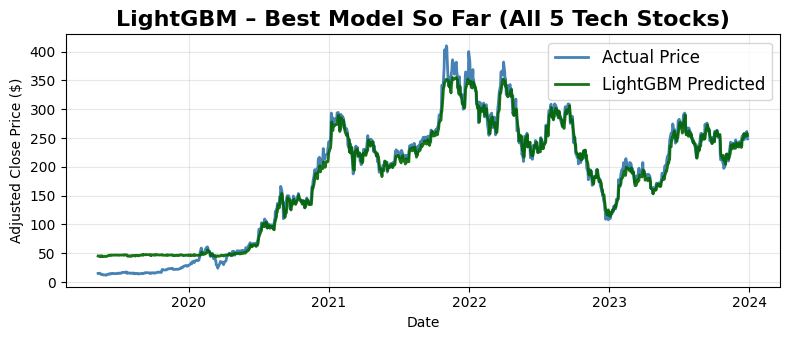

In [243]:
# === PLOT ===
plt.figure(figsize=(8, 3.5))
plt.plot(results['Date'], results['Actual'], label='Actual Price', linewidth=2, color='steelblue')
plt.plot(results['Date'], results['Predicted'], label='LightGBM Predicted', linewidth=2, color='darkgreen', alpha=0.9)
plt.title('LightGBM – Best Model So Far (All 5 Tech Stocks)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [244]:
# MODEL 6: XGBoost Regressor
dtrain = xgb.DMatrix(X_train, label=y_train)   # Training data
dtest  = xgb.DMatrix(X_test,  label=y_test)    # Test/validation data (used for early stopping)

params = {
    'objective'        : 'reg:squarederror',   # We want to minimize squared error
    'eval_metric'      : 'mae',                # Monitor Mean Absolute Error during training
    'eta'              : 0.05,                 # Learning rate (smaller = more robust)
    'max_depth'        : 6,                    # Max tree depth (6–8 is good for tabular data)
    'subsample'        : 0.8,                  # Use 80% of rows per tree → reduces overfitting
    'colsample_bytree' : 0.8,                  # Use 80% of features per tree
    'seed'             : 42,                   # For reproducibility
    'verbosity'        : 0                     # 0 = silent, 1 = info, 2 = warning
}

# We allow up to 2000 trees, but stop if no improvement in 100 rounds
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,                     # Maximum number of trees
    evals=[(dtest, 'valid')],                 # Validation set (named 'valid')
    early_stopping_rounds=100,                # Stop if MAE doesn't improve for 100 rounds
    verbose_eval=100                          # Print progress every 100 rounds
)

# Best iteration is automatically saved
best_iter = model_xgb.best_iteration
print(f"\nXGBoost stopped early at iteration {best_iter} (saved ~{2000 - best_iter} trees)")
pred_xgb = model_xgb.predict(dtest, iteration_range=(0, best_iter + 1))

[0]	valid-mae:91.92157
[100]	valid-mae:12.23627
[200]	valid-mae:12.00793
[277]	valid-mae:12.02492

XGBoost stopped early at iteration 178 (saved ~1822 trees)


In [245]:
mae  = mean_absolute_error(y_test, pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
mape = mean_absolute_percentage_error(y_test, pred_xgb) * 100
r2   = r2_score(y_test, pred_xgb)
evs  = explained_variance_score(y_test, pred_xgb)
maxe = max_error(y_test, pred_xgb)

print(f"\nXGBOOST FINAL RESULTS (Best Iteration: {best_iter}):")
print(f"   MAE                : {mae:.3f}")
print(f"   RMSE               : {rmse:.3f}")
print(f"   MAPE               : {mape:.2f}%")
print(f"   R² Score           : {r2:.4f}")
print(f"   Explained Variance : {evs:.4f}")
print(f"   Max Error          : {maxe:.3f}")


XGBOOST FINAL RESULTS (Best Iteration: 178):
   MAE                : 11.987
   RMSE               : 15.720
   MAPE               : 28.24%
   R² Score           : 0.9769
   Explained Variance : 0.9771
   Max Error          : 61.455


In [246]:
results_xgb = pd.DataFrame({
    'Date'      : dates_test.reset_index(drop=True),
    'Ticker'    : tickers_test.reset_index(drop=True),
    'Actual'    : np.round(y_test.values, 2),
    'Predicted' : np.round(pred_xgb, 2),
    'Error'     : np.round(y_test.values - pred_xgb, 2)
})

print("\nLast 10 Predictions:")
print(results_xgb.tail(10).to_string(index=False))


Last 10 Predictions:
      Date Ticker  Actual  Predicted  Error
2023-12-14   TSLA  253.50 248.639999   4.86
2023-12-15   TSLA  252.08 246.039993   6.04
2023-12-18   TSLA  257.22 249.889999   7.33
2023-12-19   TSLA  247.14 255.919998  -8.78
2023-12-20   TSLA  254.50 250.210007   4.29
2023-12-21   TSLA  252.54 251.229996   1.31
2023-12-22   TSLA  256.61 250.509995   6.10
2023-12-26   TSLA  261.44 256.450012   4.99
2023-12-27   TSLA  253.18 258.250000  -5.07
2023-12-28   TSLA  248.48 250.720001  -2.24


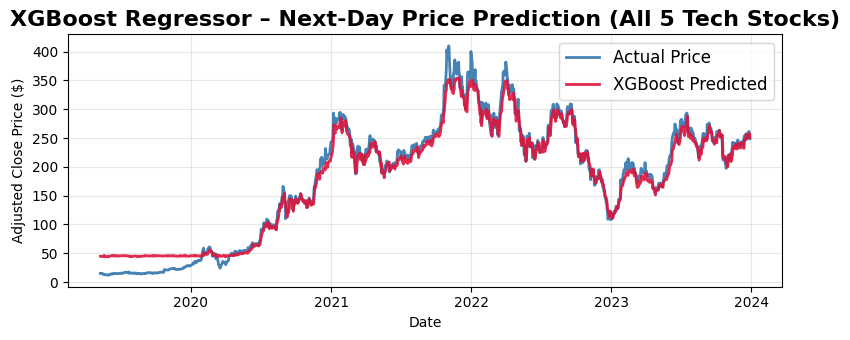

In [247]:
plt.figure(figsize=(8, 3.5 ))
plt.plot(results_xgb['Date'], results_xgb['Actual'], label='Actual Price', linewidth=2, color='steelblue')
plt.plot(results_xgb['Date'], results_xgb['Predicted'], 
         label='XGBoost Predicted', linewidth=2, color='crimson', alpha=0.9)
plt.title('XGBoost Regressor – Next-Day Price Prediction (All 5 Tech Stocks)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 8. UNSUPERVISED MACHINE LEARNING MODELS

In [248]:
feature_cols_unsup = [
    'Open', 'High', 'Low', 'Volume', 'Daily_Return', 'Volatility_30d',
    'MA7', 'MA30', 'MA90', 'Lag_Close_1', 'Lag_Close_2', 'Lag_Close_3', 'Lag_Close_5',
    'Momentum_5d', 'Momentum_10d', 'Price_Position_20d',
    'Volume_MA20', 'Volume_Ratio', 'HL_Range', 'Typical_Price', 'Overnight_Gap',
    'Year', 'Month', 'DayOfWeek'
]

X_unsup_raw = df_clean[feature_cols_unsup]
X_unsup = pd.DataFrame(StandardScaler().fit_transform(X_unsup_raw), columns=feature_cols_unsup)
print(f"Unsupervised dataset: {X_unsup.shape[0]:,} samples × {X_unsup.shape[1]} features")

Unsupervised dataset: 5,845 samples × 24 features


In [249]:
# TYPE 1: CLUSTERING – K-Means (Market Regime Detection)
# Fit K-Means with 4 clusters (typical for market regimes: bull/bear/sideways/high-vol)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_clean['KMeans_Regime'] = kmeans.fit_predict(X_unsup)

# Metrics
sil_score = silhouette_score(X_unsup, df_clean['KMeans_Regime'])
print(f"Silhouette Score: {sil_score:.4f} (0.5+ = good separation)")

Silhouette Score: 0.2061 (0.5+ = good separation)


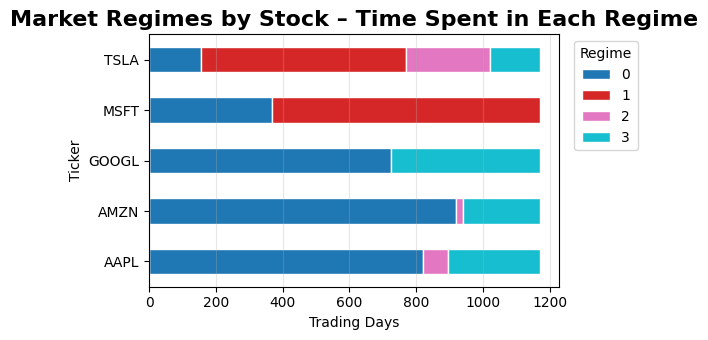


Regime Duration Table:
KMeans_Regime    0    1    2    3
Ticker                           
AAPL           820    0   74  275
AMZN           920    0   19  230
GOOGL          723    0    0  446
MSFT           368  801    0    0
TSLA           157  613  251  148


In [250]:
# Stacked bar chart: Time spent in each regime per stock
regime_counts = df_clean.groupby(['Ticker', 'KMeans_Regime']).size().unstack(fill_value=0)
regime_counts = regime_counts[sorted(regime_counts.columns)]

plt.figure(figsize=(6, 3.5))
regime_counts.plot(kind='barh', stacked=True, cmap='tab10', ax=plt.gca(), linewidth=1, edgecolor='white')
plt.title('Market Regimes by Stock – Time Spent in Each Regime', fontsize=16, fontweight='bold')
plt.xlabel('Trading Days')
plt.ylabel('Ticker')
plt.legend(title='Regime', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRegime Duration Table:")
print(regime_counts)

In [251]:
# TYPE 2: ANOMALY DETECTION – Isolation Forest (Flash Crashes & Spikes)

# Detect anomalies (2% contamination = ~1 extreme day per month)
iso_forest = IsolationForest(contamination=0.02, random_state=42, n_jobs=-1)
df_clean['Is_Anomaly'] = iso_forest.fit_predict(X_unsup)

# Metrics & counts
anomaly_rate = (df_clean['Is_Anomaly'] == -1).mean() * 100
print(f"Anomaly Detection Rate: {anomaly_rate:.2f}% ({len(df_clean[df_clean['Is_Anomaly'] == -1]):,} extreme days detected)")
print(f"False positive rate: {anomaly_rate:.2f}% (adjust contamination to change)")

# Show top anomalies
anomalies = df_clean[df_clean['Is_Anomaly'] == -1].copy()
anomalies = anomalies.sort_values('Daily_Return', key=abs, ascending=False).head(10)

print("\nTop 10 Extreme Days Detected:")
print(anomalies[['Date', 'Ticker', 'Daily_Return', 'Volume_Ratio']].round(3))

Anomaly Detection Rate: 2.00% (117 extreme days detected)
False positive rate: 2.00% (adjust contamination to change)

Top 10 Extreme Days Detected:
           Date Ticker  Daily_Return  Volume_Ratio
4860 2020-02-03   TSLA         0.158         2.205
5380 2022-02-24   TSLA         0.143         1.689
4892 2020-03-19   TSLA         0.141         1.590
5307 2021-11-09   TSLA        -0.128         1.821
5006 2020-08-31   TSLA         0.121         1.564
5422 2022-04-26   TSLA        -0.120         1.926
5361 2022-01-27   TSLA        -0.112         1.667
4862 2020-02-05   TSLA        -0.108         1.905
4908 2020-04-13   TSLA         0.103         1.164
4793 2019-10-25   TSLA         0.102         3.199


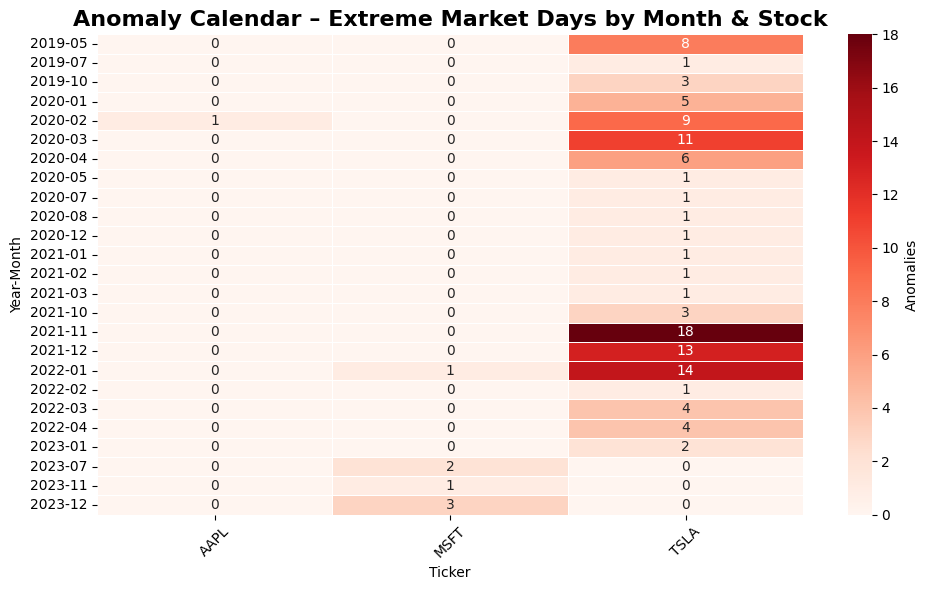

In [252]:
# Calendar heatmap of anomalies
anomaly_heatmap = df_clean[df_clean['Is_Anomaly'] == -1].copy()
anomaly_heatmap['YearMonth'] = anomaly_heatmap['Date'].dt.to_period('M').astype(str)
heatmap_data = anomaly_heatmap.groupby(['YearMonth', 'Ticker']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt="d", linewidths=0.5, cbar_kws={'label': 'Anomalies'})
plt.title('Anomaly Calendar – Extreme Market Days by Month & Stock', fontsize=16, fontweight='bold')
plt.xlabel('Ticker')
plt.ylabel('Year-Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [253]:
# TYPE 3: DIMENSIONALITY REDUCTION – PCA (Feature Compression)
# Fit PCA (keep all components for analysis)
pca_model = PCA(random_state=42)
pca_components = pca_model.fit_transform(X_unsup)
explained_var = pca_model.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Components needed for 95% variance
n_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Components for 95% variance: {n_95}/{len(explained_var)}")
print(f"First 3 components explain: {cum_var[2]*100:.1f}% of variance")

Components for 95% variance: 10/24
First 3 components explain: 71.2% of variance


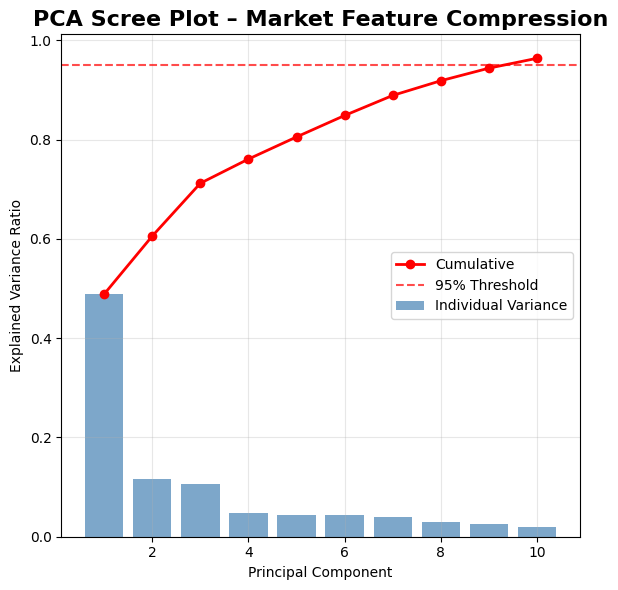

In [254]:
# Scree plot with cumulative line
plt.figure(figsize=(6, 6))
plt.bar(range(1, 11), explained_var[:10], alpha=0.7, color='steelblue', label='Individual Variance')
plt.plot(range(1, 11), cum_var[:10], 'ro-', linewidth=2, markersize=6, label='Cumulative')
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Threshold')
plt.title('PCA Scree Plot – Market Feature Compression', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

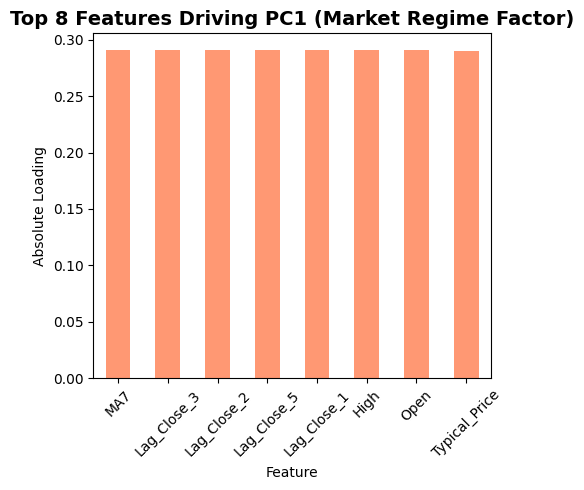

In [255]:
# Top features driving PC1 (market regime indicator)
pc1_loadings = pd.Series(pca_model.components_[0], index=feature_cols_unsup).abs().nlargest(8)
plt.figure(figsize=(5, 5))
pc1_loadings.plot(kind='bar', color='coral', alpha=0.8)
plt.title('Top 8 Features Driving PC1 (Market Regime Factor)', fontsize=14, fontweight='bold')
plt.ylabel('Absolute Loading')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [256]:
# TYPE 4: DENSITY ESTIMATION – Gaussian Mixture Model (Market States)

# Fit GMM (4 components = soft clustering)
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
df_clean['GMM_State'] = gmm.fit_predict(X_unsup)
probs = pd.DataFrame(gmm.predict_proba(X_unsup),
                     columns=[f'State_{i}' for i in range(4)])
prob_df = pd.concat([df_clean[['Date','Ticker']].reset_index(drop=True), probs], axis=1)

gmm_sil = silhouette_score(X_unsup, df_clean['GMM_State'])
print(f"GMM Silhouette Score: {gmm_sil:.4f}")
print(f"Log Likelihood: {gmm.lower_bound_:.1f}")

GMM Silhouette Score: 0.1830
Log Likelihood: 16.0


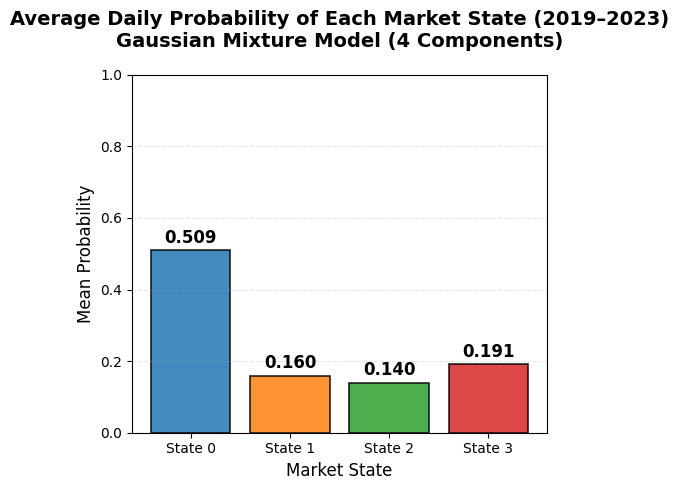

In [ ]:
# Daily average probabilities per state (only numeric columns)
daily_avg = prob_df.groupby('Date').mean(numeric_only=True)  # Key fix
overall_mean = daily_avg.mean()  # Now safe: all columns are numeric

# For nicer state names (optional)
state_names = ['State 0', 'State 1', 'State 2', 'State 3']

# Your 4 original colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Vertical bar chart
plt.figure(figsize=(5, 5))
bars = plt.bar(state_names, overall_mean.values, 
               color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Average Daily Probability of Each Market State (2019–2023)\nGaussian Mixture Model (4 Components)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Market State', fontsize=12)
plt.ylabel('Mean Probability', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


In [258]:
# Show state transitions per ticker
print("\nMarket State Distribution per Stock:")
state_dist = df_clean.groupby('Ticker')['GMM_State'].value_counts(normalize=True).unstack(fill_value=0).round(3)
print(state_dist)


Market State Distribution per Stock:
GMM_State      0      1      2      3
Ticker                               
AAPL       0.643  0.000  0.304  0.053
AMZN       0.840  0.000  0.035  0.125
GOOGL      0.883  0.000  0.099  0.018
MSFT       0.157  0.781  0.001  0.062
TSLA       0.030  0.021  0.257  0.692


# 9. Neural Network 

In [259]:
# MODEL 1: MLP Regressor (scikit-learn) – Fast & Clean
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

mlp.fit(X_train, y_train)
pred_mlp = mlp.predict(X_test)

In [260]:
# Metrics
mae = mean_absolute_error(y_test, pred_mlp)
rmse = np.sqrt(mean_squared_error(y_test, pred_mlp))
mape = mean_absolute_percentage_error(y_test, pred_mlp) * 100
r2 = r2_score(y_test, pred_mlp)

print(f"MLP Results → MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
print(f"Converged in {mlp.n_iter_} iterations")

MLP Results → MAE: 12.027 | RMSE: 15.372 | MAPE: 18.83% | R²: 0.9779
Converged in 128 iterations


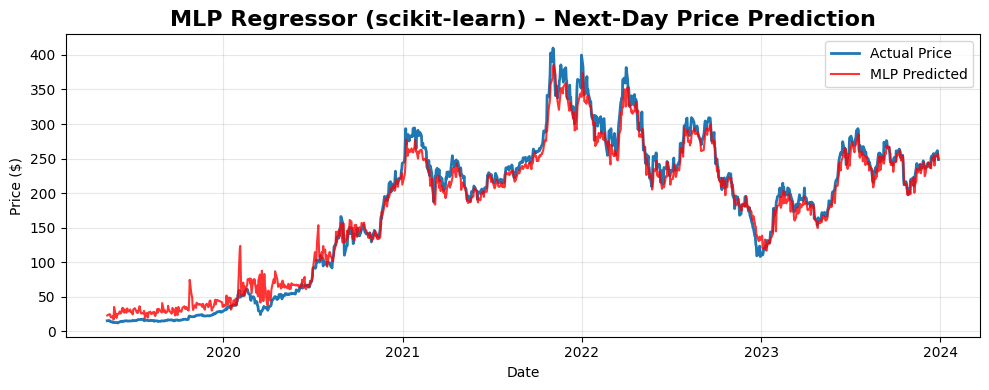

In [261]:
# Plot
results_mlp = pd.DataFrame({'Date': dates_test, 'Actual': y_test, 'Predicted': pred_mlp})
plt.figure(figsize=(10, 4))
plt.plot(results_mlp['Date'], results_mlp['Actual'], label='Actual Price', linewidth=2)
plt.plot(results_mlp['Date'], results_mlp['Predicted'], label='MLP Predicted', color='red', alpha=0.8)
plt.title('MLP Regressor (scikit-learn) – Next-Day Price Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(); 
plt.grid(alpha=0.3); 
plt.tight_layout(); 
plt.show()

In [262]:
# MODEL 2: Simple Keras Neural Network (2 Hidden Layers)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output: next-day price
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,953 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

In [263]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict
pred_keras = model.predict(X_test).flatten()

Epoch 1/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8879.6299 - mae: 81.0575 - val_loss: 2388.8423 - val_mae: 40.2257
Epoch 2/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 861.1976 - mae: 23.0256 - val_loss: 8275.4482 - val_mae: 75.8393
Epoch 3/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 496.9248 - mae: 17.5724 - val_loss: 8538.7461 - val_mae: 78.7224
Epoch 4/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 411.9105 - mae: 15.9396 - val_loss: 5697.2432 - val_mae: 63.5466
Epoch 5/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 346.8103 - mae: 14.7426 - val_loss: 6166.3354 - val_mae: 66.8102
Epoch 6/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 318.9441 - mae: 14.0550 - val_loss: 5639.0845 - val_mae: 64.6768
Epoch 7/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 276.6445 - mae: 13.1769 - val_loss: 4482.3872 - val_mae: 57.8323
Epoch 8/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 253.7146 - mae: 12.4419 - val_loss: 3927.2493 - val_mae:

In [264]:
# Metrics
mae = mean_absolute_error(y_test, pred_keras)
rmse = np.sqrt(mean_squared_error(y_test, pred_keras))
mape = mean_absolute_percentage_error(y_test, pred_keras) * 100
r2 = r2_score(y_test, pred_keras)

print(f"\nKeras NN → MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
print(f"Best epoch: {len(history.history['loss'])}")


Keras NN → MAE: 12.526 | RMSE: 15.998 | MAPE: 21.46% | R²: 0.9761
Best epoch: 75


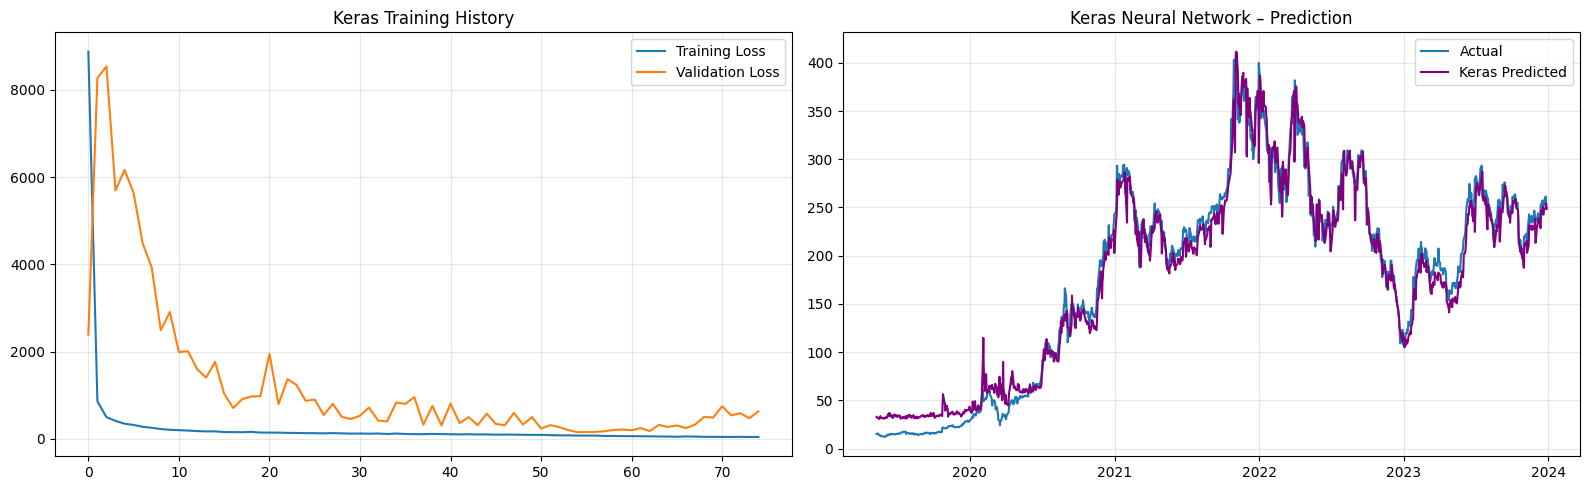

In [265]:
# Plot training + prediction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Keras Training History'); ax1.legend(); ax1.grid(alpha=0.3)

results_keras = pd.DataFrame({'Date': dates_test, 'Actual': y_test, 'Predicted': pred_keras})
ax2.plot(results_keras['Date'], results_keras['Actual'], label='Actual')
ax2.plot(results_keras['Date'], results_keras['Predicted'], label='Keras Predicted', color='purple')
ax2.set_title('Keras Neural Network – Prediction'); ax2.legend(); ax2.grid(alpha=0.3)

plt.tight_layout(); plt.show()

In [266]:
# MODEL 3: Wide & Deep Neural Network (Keras Functional API)
# Wide path (linear)
input_layer = Input(shape=(X_train.shape[1],))
wide = Dense(64, activation='linear')(input_layer)

# Deep path
deep = Dense(128, activation='relu')(input_layer)
deep = Dropout(0.3)(deep)
deep = Dense(64, activation='relu')(deep)
deep = Dropout(0.3)(deep)
deep = Dense(32, activation='relu')(deep)

In [267]:
# Combine wide + deep
combined = Concatenate()([wide, deep])
output = Dense(1)(combined)

wide_deep = Model(inputs=input_layer, outputs=output)
wide_deep.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])

wide_deep.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=64,
              callbacks=[EarlyStopping(patience=15, restore_best_weights=True)], verbose=1)

pred_wd = wide_deep.predict(X_test).flatten()

Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 15344.2451 - mae: 117.9220 - val_loss: 73075.1797 - val_mae: 265.3924
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10746.2061 - mae: 92.0474 - val_loss: 65308.3984 - val_mae: 250.1599
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5139.3311 - mae: 60.7032 - val_loss: 14399.1934 - val_mae: 118.5525
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1585.0906 - mae: 32.0966 - val_loss: 7057.6084 - val_mae: 68.6378
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 937.8975 - mae: 24.4729 - val_loss: 9144.9902 - val_mae: 78.7431
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 757.7503 - mae: 21.8027 - val_loss: 8762.2451 - val_mae: 77.1710
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 660.8561 - mae: 20.2025 - val_loss: 9304.5352 - val_mae: 80.1236
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 587.5216 - mae: 19.2167 - val_loss: 9705.0879 - val_mae: 82

In [268]:
mae = mean_absolute_error(y_test, pred_wd)
rmse = np.sqrt(mean_squared_error(y_test, pred_wd))
r2 = r2_score(y_test, pred_wd)

print(f"\nWide & Deep → MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")


Wide & Deep → MAE: 12.007 | RMSE: 16.743 | R²: 0.9738


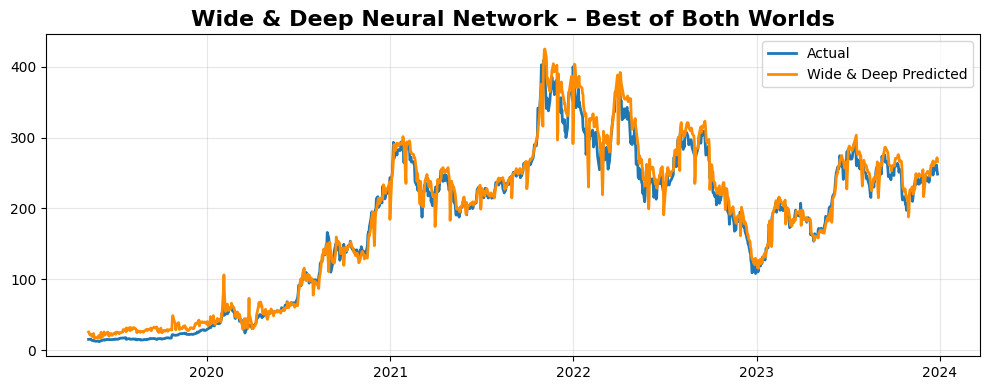

In [269]:
plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, pred_wd, label='Wide & Deep Predicted', color='darkorange', linewidth=2)
plt.title('Wide & Deep Neural Network – Best of Both Worlds', fontsize=16, fontweight='bold')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()